# Electric Vehicle in Washington State: 3. Prediction (Classification)

In [1]:
import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import streamlit as st

from scipy.stats import spearmanr

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, f_classif, chi2, SelectKBest, SelectFdr, SelectPercentile, RFE, RFECV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

In [2]:
from IPython.display import display, HTML

def print_all(df): 
    with pd.option_context('display.max_rows',None):
        with pd.option_context('display.max_columns',None):
            with pd.option_context('display.float_format', '{:,.4f}'.format):
                with pd.option_context('display.float_format', '{:,.4f}'.format): # 셀 안의 내용 전체 출력
                    print(df.shape)
                    display(df)

def print_cols(df, n=5): 
    with pd.option_context('display.max_columns',None):
        with pd.option_context('display.float_format', '{:,.4f}'.format):
            print(df.shape)
            display(df[:n])

In [3]:
def load_data():
    with open('data_processed/ev.pickle', 'rb') as f:
        ev = pickle.load(f)
    with open('data_processed/ev_merged.pickle', 'rb') as f:
        ev_merged = pickle.load(f)
    with open('data_processed/ev_state.pickle', 'rb') as f:
        ev_state = pickle.load(f)
    return ev, ev_merged, ev_state

ev, ev_merged, ev_state = load_data()

In [4]:
print_cols(ev_merged, 2)

(49, 25)


,legislative_district,ev_count,registered_voters,ballots_cast,%_turnout,patty_murray,tiffany_smiley,party_won,charger_count,geoid,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length,charger_density,charger_density_per_100,charger_ev_ratio,party_won_encoded,transformed_ev_count,transformed_charger_count,transformed_charger_ev_ratio,transformed_charger_density
0,41,12994,98278,65840,0.6699,45730,19526,Democratic,53,61000US53041,176908,4036,1.0598,"306,763.8140","1,667,039,196.5100","340,035,312.1016","138,532.7913",0.0000,0.0000,0.0041,0,113.9912,7.2801,0.0639,0.0002
1,45,12003,96577,67381,0.6977,46385,20531,Democratic,29,61000US53045,162491,5810,1.4077,"409,524.5479","2,890,039,170.5800","592,170,747.9688","185,351.7548",0.0000,0.0000,0.0024,0,109.5582,5.3852,0.0492,0.0001


In [5]:
print_cols(ev, 2)

(204997, 17)


,vin,county,city,state,postal_code,model_year,make,model,ev_type,cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,vehicle_location,electric_utility,2020_census_tract
0,JTMAB3FV3P,Kitsap,Seabeck,WA,98380,2023,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42.0000,0.0000,35,240684006,POINT (-122.8728334 47.5798304),PUGET SOUND ENERGY INC,53035091301
1,1N4AZ1CP6J,Kitsap,Bremerton,WA,98312,2018,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,151.0000,0.0000,35,474183811,POINT (-122.6961203 47.5759584),PUGET SOUND ENERGY INC,53035080700


In [6]:
print_cols(ev_state, 2)

(51, 2)


,state,registration_count
0,California,1256646
1,Florida,254878


- 다른 주에서도 이 모델을 이용한다고 가정했을 때, 이걸 가중치로 이용하는건 안 되겠지?

## Feature Engineering

In [7]:
# rename vote counts columns
ev_merged.rename(
    columns={'patty_murray':'dem_votes',
             'tiffany_smiley':'rep_votes'},
    inplace=True)

In [23]:
# ev type counts by ld

# ev.groupby('legislative_district')['ev_type'].value_counts().unstack()
# ev_type_cnt = ev.pivot_table(
#     index='legislative_district', 
#     columns='ev_type', 
#     aggfunc='size', 
#     fill_value=0)\
#     .rename_axis(None, axis=1).reset_index()
# ev_type_cnt.rename(columns={'Battery Electric Vehicle (BEV)':'bev_count', 
#                             'Plug-in Hybrid Electric Vehicle (PHEV)':'phev_count'}
#                    , inplace=True)
# ev_type_cnt.head()

# -> this is related with ev count; so shold not use these as predictors

,legislative_district,bev_count,phev_count
0,1,7619,1327
1,10,2715,851
2,11,5381,3392
3,12,1498,436
4,13,1128,375


In [8]:
# mean and median electric ranges by ld
# electric range: "Describes how far a vehicle can travel purely on its electric charge."

# ev['electric_range'].apply(lambda x: isinstance(x, str)).sum()
# ev.groupby('legislative_district')['electric_range'].agg('mean').rename('test')

# avg_elec_range = ev.pivot_table(
#     index='legislative_district', 
#     values='electric_range', 
#     aggfunc=['mean', 'median'], 
#     fill_value=0)\
#     .reset_index().rename(columns={'electric_range':'avg_electric_range'})
# avg_elec_range.head()

# 0 (null) -> fill/replace with 30
# reference: 
# "Electric Range is no longer maintained for Battery Electric Vehicles (BEV) because new BEVs have an electric range of 30 miles or more. 
# Zero (0) will be entered where the electric range has not been researched."

temp = pd.concat([ev['legislative_district'], ev['electric_range'].replace(0, np.nan)], axis=1).copy()
elec_range_vars = temp.pivot_table(
    index='legislative_district', 
    values='electric_range', 
    aggfunc=['mean', 'median'],
    fill_value=30 # instead of 0, use 30 in the calculations
).reset_index()

# Flatten the MultiIndex columns
elec_range_vars.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in elec_range_vars.columns]

# Rename columns for clarity
elec_range_vars = elec_range_vars.rename(columns={
    'legislative_district_': 'legislative_district',
    'mean_electric_range': 'avg_electric_range'
})
elec_range_vars.head()

,legislative_district,avg_electric_range,median_electric_range
0,1,132.294821,87.0
1,10,120.481711,75.0
2,11,71.717720,32.0
3,12,122.060738,75.0
4,13,118.394406,53.0


In [9]:
# mean and median base msrp by ld
# base msrp: "This is the lowest Manufacturer's Suggested Retail Price (MSRP) for any trim level of the model in question."

# avg_base_msrp = ev.pivot_table(
#     index='legislative_district', 
#     values='base_msrp', 
#     aggfunc='mean', 
#     fill_value=0)\
#     .reset_index().rename(columns={'base_msrp':'avg_base_msrp'})
# avg_base_msrp.head()

# 0 (null) -> exclude

temp = pd.concat([ev['legislative_district'], ev['base_msrp'].replace(0, np.nan)], axis=1).copy()
base_msrp_vars = temp.pivot_table(
    index='legislative_district', 
    values='base_msrp', 
    aggfunc=['mean', 'median'],
    dropna=True # exclude null values in the calculations
).reset_index()

# Flatten the MultiIndex columns
base_msrp_vars.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in base_msrp_vars.columns]

# Rename columns for clarity
base_msrp_vars = base_msrp_vars.rename(columns={
    'legislative_district_': 'legislative_district',
    'mean_base_msrp': 'avg_base_msrp'
})
base_msrp_vars.head()

,legislative_district,avg_base_msrp,median_base_msrp
0,1,54153.455285,53400.0
1,10,57766.521739,59900.0
2,11,52858.863636,54175.0
3,12,62646.756757,69900.0
4,13,56831.600000,69900.0


In [10]:
# mean and median model year by ld

model_year_vars = ev.pivot_table(
    index='legislative_district', 
    values='model_year', 
    aggfunc=['mean', 'median'], 
    dropna=True # exclude null values in the calculations
).reset_index()

# Flatten the MultiIndex columns
model_year_vars.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in model_year_vars.columns]

# Rename columns for clarity
model_year_vars = model_year_vars.rename(columns={
    'legislative_district_': 'legislative_district',
    'mean_model_year': 'avg_model_year'
})
model_year_vars.head()

,legislative_district,avg_model_year,median_model_year
0,1,2021.261234,2022.0
1,10,2020.533651,2022.0
2,11,2022.047190,2023.0
3,12,2020.793692,2022.0
4,13,2020.796407,2022.0


In [11]:
# merge
ev_merged = pd.merge(left=ev_merged, right=elec_range_vars, how='left', on='legislative_district')
ev_merged = pd.merge(left=ev_merged, right=base_msrp_vars, how='left', on='legislative_district')
ev_merged = pd.merge(left=ev_merged, right=model_year_vars, how='left', on='legislative_district')
print_cols(ev_merged, 2)

(49, 31)


,legislative_district,ev_count,registered_voters,ballots_cast,%_turnout,dem_votes,rep_votes,party_won,charger_count,geoid,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length,charger_density,charger_density_per_100,charger_ev_ratio,party_won_encoded,transformed_ev_count,transformed_charger_count,transformed_charger_ev_ratio,transformed_charger_density,avg_electric_range,median_electric_range,avg_base_msrp,median_base_msrp,avg_model_year,median_model_year
0,41,12994,98278,65840,0.6699,45730,19526,Democratic,53,61000US53041,176908,4036,1.0598,"306,763.8140","1,667,039,196.5100","340,035,312.1016","138,532.7913",0.0000,0.0000,0.0041,0,113.9912,7.2801,0.0639,0.0002,144.9304,200.0000,"62,310.8475","69,900.0000","2,021.2598","2,022.0000"
1,45,12003,96577,67381,0.6977,46385,20531,Democratic,29,61000US53045,162491,5810,1.4077,"409,524.5479","2,890,039,170.5800","592,170,747.9688","185,351.7548",0.0000,0.0000,0.0024,0,109.5582,5.3852,0.0492,0.0001,142.2772,151.0000,"58,718.9512","69,900.0000","2,021.1352","2,022.0000"


- remove party_won, and use numrical vars only?
- already have dem_votes, rep_votes

---

## Class Labeling

Background:  
- Classification Problem  
    - Categorize `ev_count` into ranges and classify into classes for modeling.  
    - Expect improved model prediction stability.  
    - Easier to understand the level of EV (electric vehicle) adoption by region.  

Class Assignment Steps:  
- Assign classes before splitting the data (train-test split).  
- Assigning classes before splitting ensures consistent class classification by considering the distribution of the entire dataset.  
    - Consistent Transformation: Labeling is part of preprocessing to help the model understand the data. Cleaning and applying labels before splitting ensures that the meaning of each data point remains consistent across train/test sets.  
- Prevents data leakage.  
    - If classes are assigned after splitting, there’s a risk of information being shared between the train and test sets, which is called data leakage. This can make model evaluation inaccurate.  
- Ensures consistency in model training and evaluation.  

Class Categorization Strategy:  
- Divide data into three ranges, ensuring segmentation considers data balance:  
    - Low  
    - Medium  
    - High  

Experiments with Multiple Classification Methods:  
- `percentile`: Divide into thirds using 33rd and 66th percentiles.  
- `quartile`: Divide into four groups (quartiles).  
- `gaussian`: Classify based on a normal distribution.  
- `custom`: Define ranges manually based on data characteristics.  

EV Count 분포 통계:
min: 537.00
max: 12994.00
mean: 4183.61
median: 3045.00
25%: 2004.00
75%: 5508.00
Skewness: 1.2624551870982634
Kurtosis: 1.0520433149809016


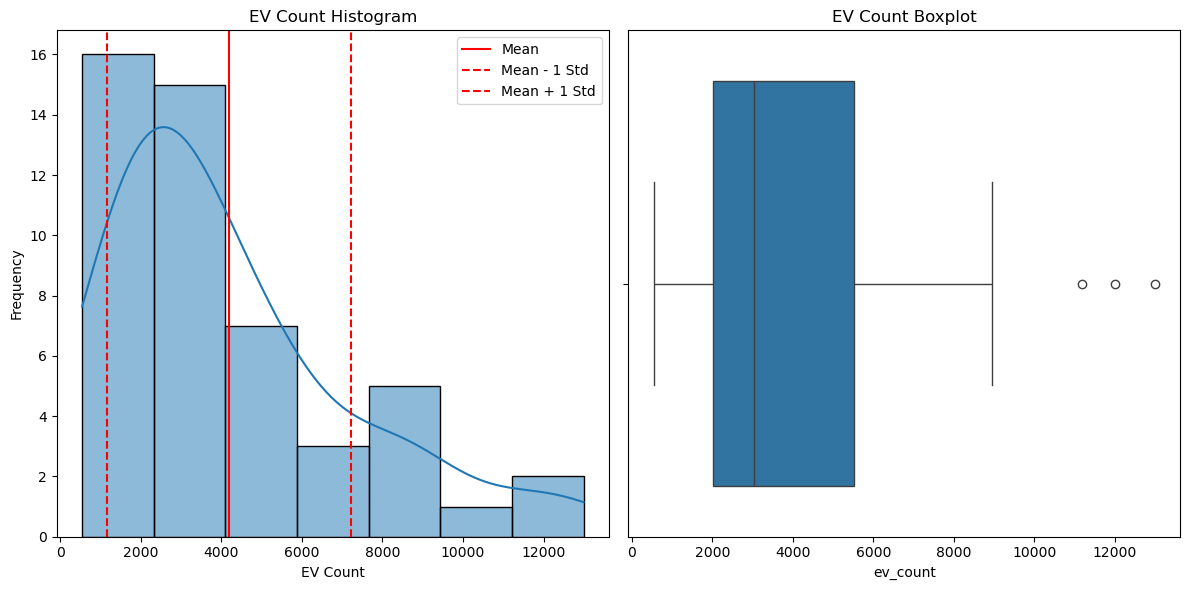

In [39]:
# Visualizing target column distribution
# Determine the best method for categorization and class labeling by checking the distribution

# EV count data from the dataset
ev_count = ev_merged['ev_count']

# Basic statistics for EV count
stats = {
    'min': ev_count.min(),
    'max': ev_count.max(),
    'mean': ev_count.mean(),
    'median': ev_count.median(),
    '25%': ev_count.quantile(0.25),
    '75%': ev_count.quantile(0.75)
}
print("EV Count 분포 통계:") # Distribution Statistics
for key, value in stats.items():
    print(f"{key}: {value:.2f}")

# Plot 1: Data distribution visualization (Histogram)
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(ev_count, kde=True)
plt.title('EV Count Histogram')
plt.xlabel('EV Count')
plt.ylabel('Frequency')

# Highlight boundaries based on normal distribution
mean, std = ev_count.mean(), ev_count.std()
plt.axvline(mean, color='r', linestyle='-', label='Mean')
plt.axvline(mean - std, color='r', linestyle='--', label='Mean - 1 Std')
plt.axvline(mean + std, color='r', linestyle='--', label='Mean + 1 Std')
plt.legend()

# Check skewness and kurtosis
print("Skewness:", ev_count.skew())
print("Kurtosis:", ev_count.kurtosis())

# Plot 2: Data distribution visualization (Boxplot)
plt.subplot(122)
sns.boxplot(x=ev_count)
plt.title('EV Count Boxplot')

plt.tight_layout()
plt.show()

Right-Skewed Distribution
- Many small values and a few large values.  
- The data is concentrated near smaller values close to 0, with some extreme large values creating a long tail to the right.  


각 분류 방법의 클래스별 통계:
                   count         mean          std     min      25%     50%      75%      max
percentile_labels                                                                            
0                   16.0  1533.625000   510.336474   537.0  1148.25  1473.0  1951.50   2219.0
1                   16.0  3232.250000   574.958491  2424.0  2836.00  2998.5  3697.75   4303.0
2                   17.0  7573.117647  2613.299564  4409.0  5508.00  7236.0  8787.00  12994.0
                 count         mean          std     min      25%     50%      75%      max
quantile_labels                                                                            
0                 16.0  1533.625000   510.336474   537.0  1148.25  1473.0  1951.50   2219.0
1                 16.0  3232.250000   574.958491  2424.0  2836.00  2998.5  3697.75   4303.0
2                 17.0  7573.117647  2613.299564  4409.0  5508.00  7236.0  8787.00  12994.0
                 count         mean          std   

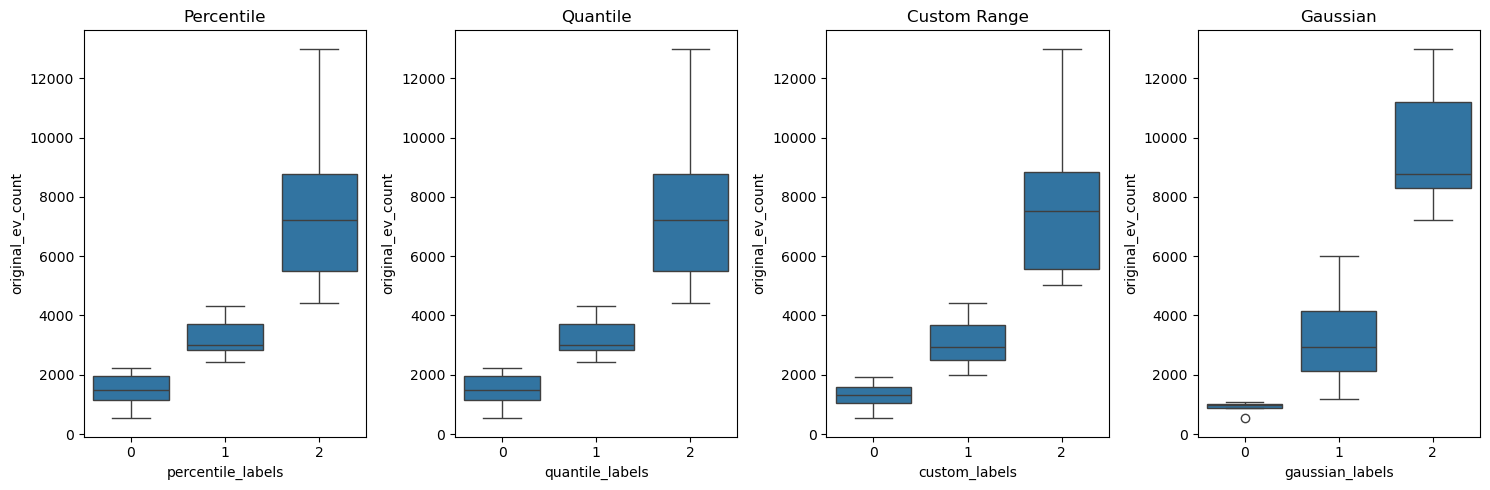

In [12]:
# Class classification
def classify_ev_count(ev_count):

    # Percentile-based Binning
    '''
    Setting class boundaries/data distribution based on specific percentiles
    Boundaries are determined using actual data values
    Directly reflects the characteristics of the data distribution
    Boundary determination: depends on the actual data values
    Recommended for irregular data distributions
    '''
    # Classify into 3 classes based on the 33rd and 66th percentiles
    low_threshold = np.percentile(ev_count, 33)
    high_threshold = np.percentile(ev_count, 66)
    
    def percentile_classifier(value):
        if value < low_threshold:
            return 0 # Low: Bottom 33%
        elif value < high_threshold:
            return 1 # Medium: 33~66%
        else:
            return 2 # High: Top 33%
    
    percentile_labels = ev_count.apply(percentile_classifier)
    
    # Quantile-based Binning
    '''
    Dividing data into groups of equal size
    Ensures completely equal data splits (always same number of data points per group)
    Focuses on the number of data points
    (Insensitive to data distribution: robust to data count)
    Choose quantile-based method when even distribution is required
    '''
    # Allocate the same number of data points to each class
    # quantile_classifier = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
    # quantile_labels = quantile_classifier.fit_transform(ev_count.values.reshape(-1, 1)).flatten()

    quantile_labels = pd.qcut(ev_count, q=3, labels=[0, 1, 2])

    # Classification based on normal distribution (mean ± std)
    mean, std = ev_count.mean(), ev_count.std()
    def gaussian_range_classifier(x):
        if x < (mean - std):
            return 0 # Low
        elif (mean - std) <= x < (mean + std):
            return 1 # Medium
        else:
            return 2 # High
    
    gaussian_labels = ev_count.apply(gaussian_range_classifier)
    
    # Custom range-based classification
    def custom_range_classifier(x):
        if x < 2000:
            return 0 # Low
        elif 2000 <= x < 5000:
            return 1 # Medium
        else:
            return 2 # High
    
    custom_labels = ev_count.apply(custom_range_classifier)
        
    # Class statistics for each classification method:
    results = pd.DataFrame({
        'original_ev_count': ev_count,
        'percentile_labels': percentile_labels,
        'quantile_labels': quantile_labels,
        'gaussian_labels': gaussian_labels,
        'custom_labels': custom_labels
    })
    
    # Check distribution by label
    print("\n각 분류 방법의 클래스별 통계:")
    # print("Percentile Labels:\n", results['percentile_labels'].value_counts())
    # print("\nQuantile Labels:\n", results['quantile_labels'].value_counts())
    # print("\nGaussian Labels:\n", results['gaussian_labels'].value_counts())
    # print("\nCustom Range Labels:\n", results['custom_labels'].value_counts())
    with pd.option_context('display.width', 1000):
        print(results.groupby('percentile_labels', observed=True)['original_ev_count'].describe())
        print(results.groupby('quantile_labels', observed=True)['original_ev_count'].describe())
        print(results.groupby('gaussian_labels', observed=True)['original_ev_count'].describe())
        print(results.groupby('custom_labels', observed=True)['original_ev_count'].describe())
    
    # Plots
    plt.figure(figsize=(15, 5))

    plt.subplot(141)
    sns.boxplot(x='percentile_labels', y='original_ev_count', data=results)
    plt.title('Percentile')
    
    plt.subplot(142)
    sns.boxplot(x='quantile_labels', y='original_ev_count', data=results)
    plt.title('Quantile')
    
    plt.subplot(143)
    sns.boxplot(x='custom_labels', y='original_ev_count', data=results)
    plt.title('Custom Range')
    
    plt.subplot(144)
    sns.boxplot(x='gaussian_labels', y='original_ev_count', data=results)
    plt.title('Gaussian')
    
    plt.tight_layout()
    plt.show()
    
    return results

ev_count = ev_merged['ev_count']
results = classify_ev_count(ev_count)

Adopting the percentile-based method
- Because it reflects the unique distribution of the data while being intuitive and easy to interpret

In [28]:
results

,original_ev_count,percentile_labels,quantile_labels,gaussian_labels,custom_labels
0,12994,2,2,2,2
1,12003,2,2,2,2
2,11184,2,2,2,2
3,8946,2,2,2,2
4,8787,2,2,2,2
5,8773,2,2,2,2
6,8297,2,2,2,2
7,7790,2,2,2,2
8,7236,2,2,2,2
9,5994,2,2,1,2


In [13]:
# class assignment

ev_merged['ev_class'] = results['percentile_labels']
print_cols(ev_merged, 2)

(49, 32)


,legislative_district,ev_count,registered_voters,ballots_cast,%_turnout,dem_votes,rep_votes,party_won,charger_count,geoid,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length,charger_density,charger_density_per_100,charger_ev_ratio,party_won_encoded,transformed_ev_count,transformed_charger_count,transformed_charger_ev_ratio,transformed_charger_density,avg_electric_range,median_electric_range,avg_base_msrp,median_base_msrp,avg_model_year,median_model_year,ev_class
0,41,12994,98278,65840,0.6699,45730,19526,Democratic,53,61000US53041,176908,4036,1.0598,"306,763.8140","1,667,039,196.5100","340,035,312.1016","138,532.7913",0.0000,0.0000,0.0041,0,113.9912,7.2801,0.0639,0.0002,144.9304,200.0000,"62,310.8475","69,900.0000","2,021.2598","2,022.0000",2
1,45,12003,96577,67381,0.6977,46385,20531,Democratic,29,61000US53045,162491,5810,1.4077,"409,524.5479","2,890,039,170.5800","592,170,747.9688","185,351.7548",0.0000,0.0000,0.0024,0,109.5582,5.3852,0.0492,0.0001,142.2772,151.0000,"58,718.9512","69,900.0000","2,021.1352","2,022.0000",2


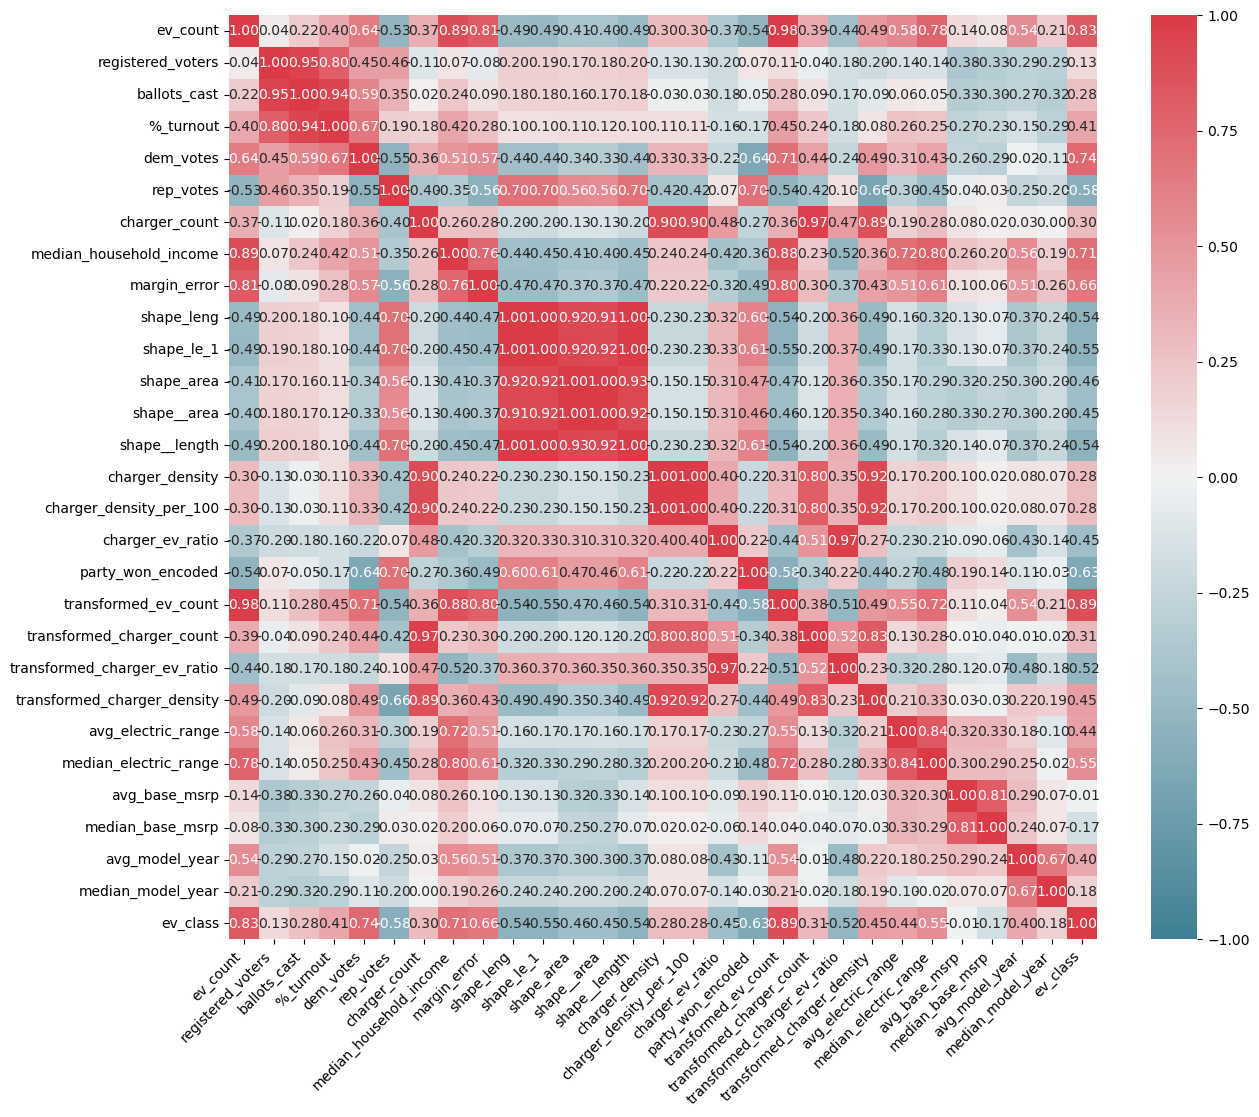

In [14]:
def get_corr_heatmap(df, title=''):
    my_colormap = sns.diverging_palette(220, 10, as_cmap=True) # custom diverging colormap
    plt.figure(figsize=(14, 12))
    corr_matrix = df.corr(numeric_only=True)
    sns.heatmap(corr_matrix, annot=True, cmap=my_colormap, fmt='.2f', vmin=-1, vmax=1)
    plt.xticks(rotation=45, ha='right')
    # plt.tick_params(axis='x', bottom=False, labelbottom=False)
    plt.title(title)
    plt.show()

get_corr_heatmap(ev_merged)

### Data Split

Considerations for classification and modeling:
- Using Stratified Split (stratify=ev_class).
- Using multi-class classification algorithms (e.g., RandomForest, SVM, LogisticRegression).
- Evaluation metrics: Precision, Recall, F1-score, Confusion Matrix.

In [15]:
cols_exlucde = ['legislative_district','ev_count','geoid','party_won_encoded','charger_ev_ratio','charger_density_per_100','ev_class']
cols_use = [col for col in ev_merged.columns if col not in cols_exlucde and 'transformed' not in col]
X = ev_merged[cols_use].copy()
y = ev_merged['ev_class'].copy()

# split data into training and testing sets for model development
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=777)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print_cols(X_train, 1)
print_cols(y.to_frame(), 1)

(39, 21) (10, 21) (39,) (10,)
(39, 21)


,registered_voters,ballots_cast,%_turnout,dem_votes,rep_votes,party_won,charger_count,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length,charger_density,avg_electric_range,median_electric_range,avg_base_msrp,median_base_msrp,avg_model_year,median_model_year
22,110994,75850,0.6834,38894,36289,Democratic,35,86493,2295,2.9139,"867,905.0024","21,826,779,775.6000","4,560,129,034.8203","396,737.9207",0.0000,120.4817,75.0000,"57,766.5217","59,900.0000","2,020.5337","2,022.0000"


(49, 1)


,ev_class
0,2


In [16]:
[col for col in X_train.columns.tolist() if col != 'party_won']

['registered_voters',
 'ballots_cast',
 '%_turnout',
 'dem_votes',
 'rep_votes',
 'charger_count',
 'median_household_income',
 'margin_error',
 'shape_leng',
 'shape_le_1',
 'shape_area',
 'shape__area',
 'shape__length',
 'charger_density',
 'avg_electric_range',
 'median_electric_range',
 'avg_base_msrp',
 'median_base_msrp',
 'avg_model_year',
 'median_model_year']

In [17]:
# numeric features
num_cols = [col for col in X_train.columns.tolist() if col != 'party_won']

# categorical features
cat_cols = ['party_won']
oh_cols = []
lb_cols = ['party_won']

# Imputation and Encoding pipeline
# 1. SimpleImputer will handle missing values
# 2. OneHotEncoder and OrdinalEncoder will handle encoding

preprocessor = ColumnTransformer(
    transformers = [
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')), # handle missing values for numeric columns
            ('scaler', StandardScaler()) # standardize numeric features
        ]), num_cols),
        ('oh', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')), # fill missing categorical data with the most frequent value
            # ('encoder', OneHotEncoder(drop='first', handle_unknown='error')) # one-hot encode categorical features
            ('encoder', OneHotEncoder(handle_unknown='error'))
        ]), oh_cols),
        ('lb', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')), # handle missing categorical data
            ('encoder', OrdinalEncoder(handle_unknown='error')) # ordinal encode
        ]), lb_cols)
    ], remainder='passthrough'
)

# Transform the training and test data
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

col_names_prep = preprocessor.get_feature_names_out()

X_train_enc = pd.DataFrame(X_train_enc, columns=col_names_prep)
X_test_enc = pd.DataFrame(X_test_enc, columns=col_names_prep)

print_cols(X_train_enc, 2)
print_cols(X_test_enc, 2)

(39, 21)


,num__registered_voters,num__ballots_cast,num__%_turnout,num__dem_votes,num__rep_votes,num__charger_count,num__median_household_income,num__margin_error,num__shape_leng,num__shape_le_1,num__shape_area,num__shape__area,num__shape__length,num__charger_density,num__avg_electric_range,num__median_electric_range,num__avg_base_msrp,num__median_base_msrp,num__avg_model_year,num__median_model_year,lb__party_won
0,1.2984,1.2675,0.9590,0.3725,0.8053,-0.2578,-0.2960,-0.6401,-0.0700,-0.0448,-0.2537,-0.2412,-0.0285,-0.4321,0.5404,0.1746,0.4324,0.0598,-0.8290,0.0928,0.0000
1,-0.7637,-1.0222,-1.1407,-0.3601,-0.5832,-0.0250,-0.3854,-0.0644,-0.6698,-0.6710,-0.5034,-0.4930,-0.6627,-0.1636,0.5564,0.4178,-0.0704,1.3316,-0.3163,0.0928,0.0000


(10, 21)


,num__registered_voters,num__ballots_cast,num__%_turnout,num__dem_votes,num__rep_votes,num__charger_count,num__median_household_income,num__margin_error,num__shape_leng,num__shape_le_1,num__shape_area,num__shape__area,num__shape__length,num__charger_density,num__avg_electric_range,num__median_electric_range,num__avg_base_msrp,num__median_base_msrp,num__avg_model_year,num__median_model_year,lb__party_won
0,0.4226,0.9205,1.3303,0.6922,0.1476,-0.1519,1.9632,2.0496,-0.1082,-0.1311,-0.3806,-0.3741,-0.1297,-0.3963,1.5623,1.1473,0.6935,0.7020,1.3533,0.0928,0.0000
1,1.0139,1.4656,1.6243,1.5398,-0.2449,0.5676,-0.4790,-0.9741,0.3299,0.3167,-0.1694,-0.1509,0.3460,-0.4091,0.1325,0.4482,-0.4903,-0.4744,-2.5505,-3.5282,0.0000


In [18]:
preprocessor.get_feature_names_out()

array(['num__registered_voters', 'num__ballots_cast', 'num__%_turnout',
       'num__dem_votes', 'num__rep_votes', 'num__charger_count',
       'num__median_household_income', 'num__margin_error',
       'num__shape_leng', 'num__shape_le_1', 'num__shape_area',
       'num__shape__area', 'num__shape__length', 'num__charger_density',
       'num__avg_electric_range', 'num__median_electric_range',
       'num__avg_base_msrp', 'num__median_base_msrp',
       'num__avg_model_year', 'num__median_model_year', 'lb__party_won'],
      dtype=object)

### Feature Selection

Filter Method -> Wrapper Method 방식
- 이 접근법은 더 엄격한 피처 선택 방식으로, filter method에서 이미 중요하다고 판단된 변수들만을 대상으로 wrapper method를 적용

참고: 순차적 필터링의 문제점
- 각 단계에서 피처를 제거하면 정보 손실 가능성
- e.g., Variance Thresholding → 통계적 방법 → FDR
    - FDR을 최종 단계가 아닌 통계적 방법론과 함께 적용

다양한 피처 선택 방법을 종합적으로 적용
- 각 방법론의 장점을 활용하여 robust한 피처 선택 가능

피처 선택 방법 사용 방향:
- 데이터 크기가 작으므로 단일 방법론에 의존하기보다는 여러 방법 병행
    - 통합된 방법론 사용, 앙상블 피처 선택 기법 고려
- 교차 검증을 통해 각 방법의 성능 비교
- 도메인 지식과 결합하여 피처 선택

주의사항:
- 49개 데이터는 매우 작은 데이터셋
- 과적합 위험이 높음
- 피처 선택 시 매우 신중해야 함
- 교차 검증과 부트스트래핑 기법 고려

# Feature Selection - Filter Method
Variance Thresholding 후 선택된 피처 (21): ['num__registered_voters', 'num__ballots_cast', 'num__%_turnout', 'num__dem_votes', 'num__rep_votes', 'num__charger_count', 'num__median_household_income', 'num__margin_error', 'num__shape_leng', 'num__shape_le_1', 'num__shape_area', 'num__shape__area', 'num__shape__length', 'num__charger_density', 'num__avg_electric_range', 'num__median_electric_range', 'num__avg_base_msrp', 'num__median_base_msrp', 'num__avg_model_year', 'num__median_model_year', 'lb__party_won']


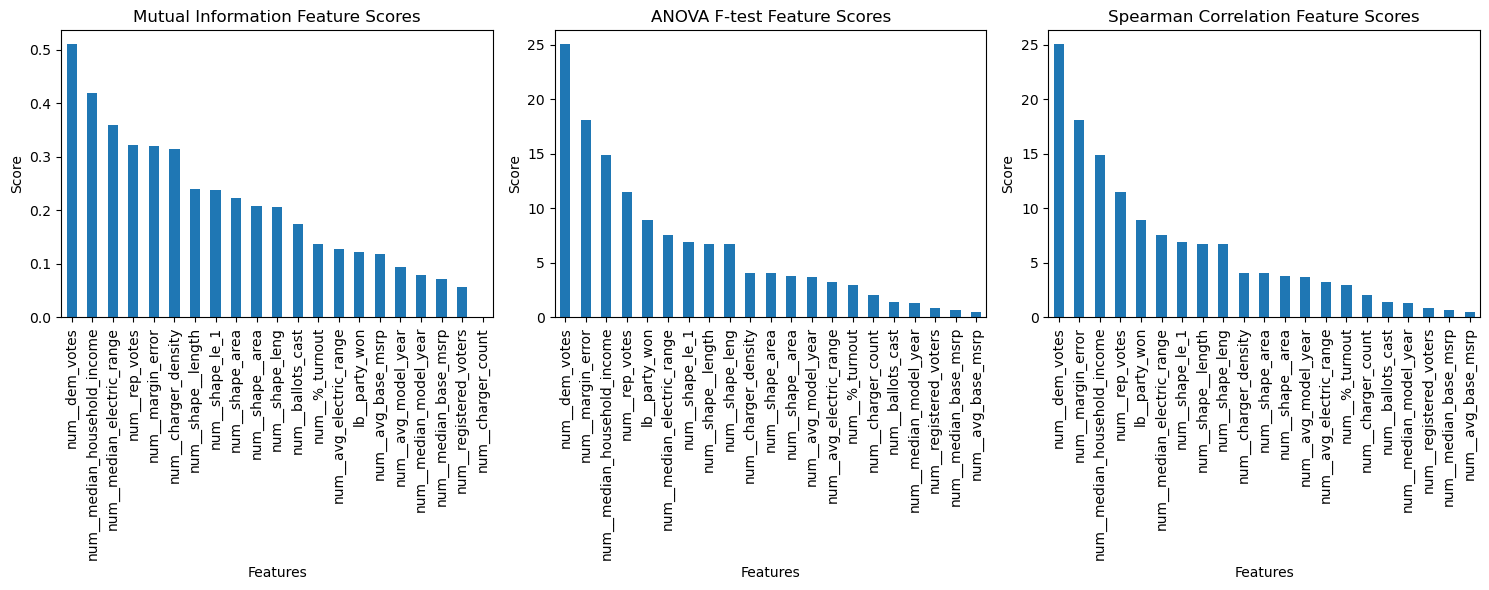

선택된 피처들 (15): ['num__charger_density', 'num__median_electric_range', 'num__avg_electric_range', 'num__shape__length', 'lb__party_won', 'num__shape_le_1', 'num__avg_model_year', 'num__rep_votes', 'num__%_turnout', 'num__shape_leng', 'num__shape__area', 'num__dem_votes', 'num__shape_area', 'num__margin_error', 'num__median_household_income']
# Feature Selection - Wrapper Method


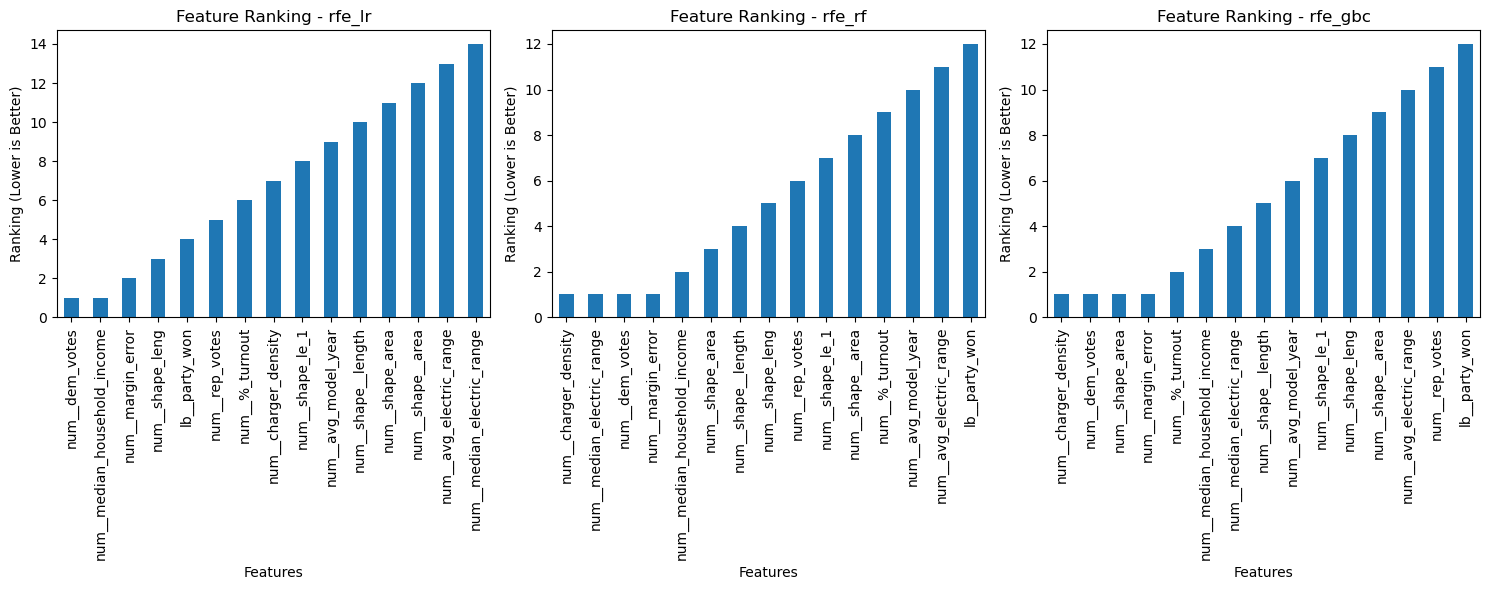

선택된 피처들 (6): ['num__charger_density', 'num__median_electric_range', 'num__dem_votes', 'num__shape_area', 'num__margin_error', 'num__median_household_income']


In [82]:
# Feature selection class
# 1) Filter method, 2) Wrapper method
# select: union or intersection
class FeatureSelector:
    def __init__(self, X_train, y_train, X_test=None):

        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test

    def sequential_filter_method(
        self, 
        variance_threshold=0.01, 
        selection_methods=['mutual_info', 'anova', 'spearman'],
        n_features=10, 
        alpha=0.05
    ):

        # 1. Variance Thresholding
        # Remove features with very low variance
        # Features with almost no variation (nearly constant values) do not provide useful information for the model
        var_selector = VarianceThreshold(threshold=variance_threshold)
        X_train_var = var_selector.fit_transform(self.X_train)
        var_selected_features = self.X_train.columns[var_selector.get_support()]
        X_train_var = pd.DataFrame(X_train_var, columns=var_selected_features)
        
        print(f"Features selected after Variance Thresholding ({len(var_selected_features)}): {list(var_selected_features)}")
        
        # Dictionary to save the results
        method_features = {}
        
        # 2. Select features using various statistical methods.
        # Evaluate feature importance based on its relationship with the target variable.
        selection_funcs = {
            'mutual_info': (mutual_info_classif, "Mutual Information"), # Mutual Information: Measures nonlinear relationships
            'anova': (f_classif, "ANOVA F-test"), # ANOVA F-test: Measures linear relationships and variance differences
            'spearman': ("spearman", "Spearman Correlation") # Spearmen Correlation
        }

        num_methods = len(selection_methods)
        plt.figure(figsize=(5 * num_methods, 6))
        
        for i, method_name in enumerate(selection_methods):
            score_func, method_label = selection_funcs[method_name]
            
            # Implement Spearman Correlation directly
            if method_name == 'spearman':
                correlation_results = []
                for feature in X_train_var.columns:
                    corr, p_value = spearmanr(X_train_var[feature], self.y_train)
                    correlation_results.append({'Feature': feature, 'Correlation': corr, 'P-Value': p_value})
                # Create DataFrame and select top n_features
                correlation_df = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
                method_selected_features = correlation_df.loc[correlation_df['P-Value'] < alpha, 'Feature'][:n_features]
                method_selected_features = list(method_selected_features)
            # Mutual Information and ANOVA F-test
            else:
                selector = SelectKBest(score_func=score_func, k=n_features)
                X_train_selected = selector.fit_transform(X_train_var, self.y_train)
                method_selected_features = X_train_var.columns[selector.get_support()]
            
            method_features[method_name] = list(method_selected_features)
            
            # Visualize feature scores
            plt.subplot(1, num_methods, i+1)
            feature_scores = pd.Series(selector.scores_, index=X_train_var.columns)
            feature_scores.sort_values(ascending=False).plot(kind='bar')
            plt.title(f'{method_label} Feature Scores')
            plt.xlabel('Features')
            plt.ylabel('Score')
            plt.tight_layout()

        plt.tight_layout()
        plt.show()
        
        return method_features
    
    def wrapper_methods(self, methods=['rfe_lr', 'rfe_rf', 'rfe_gbc'], n_features_to_select=8):

        wrapper_selected_features = {}
        
        # Define the models to use
        # Using three models: Logistic Regression, Random Forest, Gradient Boosting
        models = {
            'rfe_lr': LogisticRegression(max_iter=1000, random_state=777),
            'rfe_rf': RandomForestClassifier(n_estimators=100, random_state=777),
            'rfe_gbc': GradientBoostingClassifier(n_estimators=100, random_state=777)
        }
        
        # plt.figure(figsize=(12, 6))
        num_methods = len(methods)
        plt.figure(figsize=(5 * num_methods, 6))
        
        for i, method_name in enumerate(methods):
            model = models[method_name]

            # Recursive Feature Elimination with Cross-Validation (RFECV)
            # RFE repeatedly trains the model and removes the least important features to find the optimal feature set.
            # In RFE (Recursive Feature Elimination), lower feature rankings indicate more important features
            rfecv = RFECV(estimator=model, step=1, cv=5, scoring='f1_macro', n_jobs=-1) # accuracy, f1_macro
            rfecv.fit(self.X_train, self.y_train)
            
            # Extract selected features
            selected_features = self.X_train.columns[rfecv.support_]
            wrapper_selected_features[method_name] = list(selected_features)
            
            # Visualize feature importance
            plt.subplot(1, num_methods, i+1)
            feature_importance = pd.Series(rfecv.ranking_, index=self.X_train.columns)
            
            feature_importance.sort_values().plot(kind='bar')
            plt.title(f'Feature Ranking - {method_name}')
            plt.xlabel('Features')
            plt.ylabel('Ranking (Lower is Better)')
            plt.tight_layout()
            
        plt.tight_layout()
        plt.show()
        
        return wrapper_selected_features
 
    def get_optimal_features(self, selected_features, method='intersection'):
        # Select optimal features based on Filter and Wrapper methods' results
        if method == 'intersection':
            # Intersection; to get the most optimal features
            optimal_features = list(set.intersection(
                *[set(features) for features in selected_features.values()]
            ))
        else:
            # Union; to get optimal features as many as possible
            optimal_features = list(set().union(
                *[set(features) for features in selected_features.values()]
            ))
        
        print(f"Selected features ({len(optimal_features)}): {optimal_features}")
        # for feature in optimal_features:
        #     print(feature)
        
        return optimal_features

print('# Feature Selection - Filter Method')

feature_selector = FeatureSelector(X_train_enc, y_train)

# 1. Filter Method: Mutual Information
# filter_selected_features = feature_selector.filter_method(n_features=10)
method_features = feature_selector.sequential_filter_method(
    variance_threshold=0.01,
    selection_methods=['mutual_info', 'anova', 'spearman'],
    n_features=10,
    alpha=0.05
)
# print(method_features)

filter_selected_features = feature_selector.get_optimal_features(
    selected_features=method_features,
    method='union' # intersection, union
)
# filter_selected_features

# 2. Create subsets with variables selected by the Filter method
X_train_filtered = X_train_enc[filter_selected_features]
X_test_filtered = X_test_enc[filter_selected_features]

print('# Feature Selection - Wrapper Method')

# (추가) 3. Create a new FeatureSelector instance with filtered data
filter_feature_selector = FeatureSelector(X_train_filtered, y_train)

# 4. Perform Wrapper Methods with filtered variables only
# wrapper_selected_features = feature_selector.wrapper_methods()
wrapper_selected_features = filter_feature_selector.wrapper_methods()

# 3. Select optimal features (intersection or union method)
final_selected_features = filter_feature_selector.get_optimal_features(
    # filter_selected_features, 
    selected_features=wrapper_selected_features, 
    method='union'
)

# Create data subsets with the final selected features
X_train_selected = X_train_enc[final_selected_features]
X_test_selected = X_test_enc[final_selected_features]

---
Target:
- ev_count -> discretize

Approach: 
- Classification

Methods:
- Logistic, RF, SVM
- Cross validation

## Model Training and Testing

In [83]:
# Function to compare model performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Multi-class classification performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print confusion matrix and classification report
    print("\n혼동 행렬:")
    print(confusion_matrix(y_test, y_pred))
    print("\n분류 리포트:")
    print(classification_report(y_test, y_pred))
    
    return {
        'Accuracy': accuracy, 
        'Precision': precision, 
        'Recall': recall, 
        'F1-Score': f1
    }

# Logistic Regression
log_reg = LogisticRegression( 
    max_iter=1000, 
    random_state=777
)
log_reg_results = evaluate_model(log_reg, X_train_selected, X_test_selected, y_train, y_test)
print("\nLogistic Regression Results:")
for metric, value in log_reg_results.items():
    print(f"{metric}: {value}")

# Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=100, 
    random_state=777
)
rf_results = evaluate_model(rf_clf, X_train_selected, X_test_selected, y_train, y_test)
print("\nRandom Forest Results:")
for metric, value in rf_results.items():
    print(f"{metric}: {value}")

# XGBoost Classifier
xgb_clf = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    random_state=777,
    # use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_results = evaluate_model(xgb_clf, X_train_selected, X_test_selected, y_train, y_test)
print("\nXGBoost Results:")
for metric, value in xgb_results.items():
    print(f"{metric}: {value}")

# SVM Classifier
svm_clf = SVC(
    kernel='rbf', # Use RBF kernel (suitable for multi-class classification)
    C=1.0, # Regularization strength
    random_state=777,
    class_weight='balanced' # Handle class imbalance
)
svm_results = evaluate_model(svm_clf, X_train_selected, X_test_selected, y_train, y_test)
print("\nSVM Results:")
for metric, value in svm_results.items():
    print(f"{metric}: {value}")

# Organize results of all models into a dictionary
results = {
    'Logistic Regression': log_reg_results,
    'Random Forest': rf_results,
    'XGBoost': xgb_results,
    'SVM': svm_results
}

# Compare the performance (F1-Score) of each model
best_model_name = max(results, key=lambda k: results[k]['F1-Score'])
print(f"\nBest performing model: {best_model_name} (F1-Score: {results[best_model_name]['F1-Score']})")

# Dictionary to fetch the selected model (mapped to its class)
model_dict = {
    'Logistic Regression': log_reg,
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf,
    'SVM': svm_clf
}

# Final selected model
best_model = model_dict[best_model_name]

# hyperparameter tuning using grid search
param_grid = {
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'class_weight': [None, 'balanced']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}

def grid_search_cv(model, params, X_train, X_test, y_train, y_test):
    grid_search = GridSearchCV(
        model, 
        params, 
        cv=5, 
        scoring='f1_weighted', 
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    print(f"\nOptimal hyperparameters: {grid_search.best_params_}")
    print(f"Best model score: {grid_search.best_score_}")
    
    # Evaluate using the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    print("\nBest model performance:")
    print(classification_report(y_test, y_pred))
    
    return best_model

# Optimal model hyperparameter tuning
best_tuned_model = grid_search_cv(
    svm_clf, 
    param_grid['SVM'], 
    X_train_selected, 
    X_test_selected, 
    y_train, 
    y_test
)


혼동 행렬:
[[3 0 0]
 [0 2 1]
 [0 0 4]]

분류 리포트:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.67      0.80         3
           2       0.80      1.00      0.89         4

    accuracy                           0.90        10
   macro avg       0.93      0.89      0.90        10
weighted avg       0.92      0.90      0.90        10


Logistic Regression Results:
Accuracy: 0.9
Precision: 0.9199999999999999
Recall: 0.9
F1-Score: 0.8955555555555555

혼동 행렬:
[[3 0 0]
 [1 1 1]
 [0 0 4]]

분류 리포트:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.33      0.50         3
           2       0.80      1.00      0.89         4

    accuracy                           0.80        10
   macro avg       0.85      0.78      0.75        10
weighted avg       0.84      0.80      0.76        10


Random Forest Results:
Accuracy: